# Investigating Hybrid Strategies for Systematic Literature Review

In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2016
reload()
# !pip install matplotlib-venn

In [22]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.planilha = {
                work for work in current.visited 
                if int(getattr(work, "planilha_{}".format(current.name), 0))
            }
            current.planilha_selected = {
                work for work in current.related 
                if int(getattr(work, "planilha_{}".format(current.name), 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                (" visited", len(current.visited)),
                (" selected", len(current.related)),  #  ("WorkSnowball", len(current.related)),
                #("selected", len(current.final_selected)),
                #("seed_set", len(current.seed_set)),
            ]
            if current.planilha:
                options.append((" planilha", len(current.planilha)))
                options.append((" planilha selected", len(current.planilha_selected)))
                options.append((" duplicados", len(current.visited - current.planilha)))
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            (" visited", len(current.delta_visited)),
                            (" selected", len(current.delta_related)),
                            #("selected", len(current.delta_selected)),
                            #("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", 
        "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "excel", "excel_selected", "duplicated",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
        excel = {
            work for work in current.visited 
            if int(getattr(work, "planilha_{}".format(current.name), 0))
        }
        excel_selected = {
            work for work in current.related 
            if int(getattr(work, "planilha_{}".format(current.name), 0))
        } 
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            len(excel),
            len(excel_selected),
            len(current.visited - excel) if excel else 0,
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

# Strategies

## Strategy 1 - Database Search

In [15]:
print ("Total de estudos primários reproduzidos: 16 do Seed Set + 4 encontrados durante o Snowballing = ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários reproduzidos: 16 do Seed Set + 4 encontrados durante o Snowballing =  20


In [16]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if getattr(x, "seed_set", 0)}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function)) # busca simples

state = strategy.initial
strategy.initial.visited

FinalSelection(state);

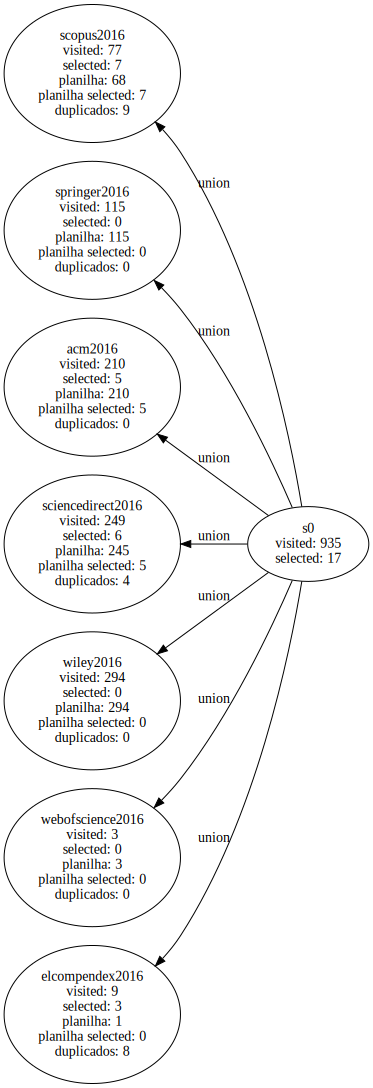

In [17]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0") 
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

bibliotecas = ["scopus2016", "springer2016", "acm2016", "sciencedirect2016", "wiley2016", "webofscience2016", "elcompendex2016",]
strategy = busca_completa(bibliotecas, filter_function)
state = strategy.initial
final = FinalSelection(strategy.initial)
final

In [18]:
{work
 for _, work in load_work_map_all_years()
 for bib in bibliotecas
 for bib2 in bibliotecas
 if bib != bib2
 if int(getattr(work, "planilha_{}".format(bib), 0))
 if int(getattr(work, "planilha_{}".format(bib2), 0))
}

{An obsolescence management framework for system baseline evolution-perspectives through the system life cycle}

In [19]:
def salvar(state, arquivo):
    with open("{}.dot".format(arquivo), "w") as f:
        f.write(state.dot)
    !dot -Tsvg {arquivo}.dot -o {arquivo}.svg
    #!inkscape -f {arquivo}.svg -e {arquivo}.png -d 300

In [8]:
salvar(final, "final")

In [20]:
#strategy.initial.seed_set @ metakey_title
strategy.initial.visited

{Ecosystem-inspired enterprise modelling framework for collaborative and networked manufacturing systems,
 The Role of Requirements In Agile System Realization,
 Agile requirements engineering practices and challenges: an empirical study,
 A multidisciplinary approach to supply chain agility: Conceptualization and scale development,
 Agile methods for open source safety-critical software,
 Embracing agile development of usable software systems,
 A framework for quality assessment of just-in-time requirements: the case of open source feature requests,
 An empirical study of the impact of CEO characteristics on new firms' time to IPO,
 Progressive Outcomes: A framework for maturing in agile software development,
 Designing social media for informal learning and knowledge maturing in the digital workplace,
 Personality characteristics in an XP team: a repertory grid study,
 Asap: a planning tool for agile software development,
 Project management aided by verbal decision analysis approach

In [24]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df = df.round(4)
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df
                                  


8,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,...,final_selected,excel,excel_selected,duplicated,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,elcompendex2016,0.333,0.188,0.240,0.0,0.0,0,-,3,9,...,1,1,0,8,0.333,0.188,0.240,0.111,0.143,0.125
1,webofscience2016,0.000,0.000,0.000,0.0,0.0,0,-,0,3,...,0,3,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,wiley2016,0.000,0.000,0.000,0.0,0.0,0,-,0,294,...,0,294,0,0,0.000,0.000,0.000,0.000,0.000,0.000
3,sciencedirect2016,0.024,0.375,0.045,0.0,0.0,0,-,6,249,...,1,245,5,4,0.024,0.375,0.045,0.004,0.143,0.008
4,acm2016,0.024,0.312,0.044,0.0,0.0,0,-,5,210,...,3,210,5,0,0.024,0.312,0.044,0.014,0.429,0.028
5,springer2016,0.000,0.000,0.000,0.0,0.0,0,-,0,115,...,0,115,0,0,0.000,0.000,0.000,0.000,0.000,0.000
6,scopus2016,0.091,0.438,0.151,0.0,0.0,0,-,7,77,...,2,68,7,9,0.091,0.438,0.151,0.026,0.286,0.048
7,s0,NaN,0.000,0.000,NaN,0.0,0,union,0,0,...,6,0,0,0,0.018,1.062,0.036,0.006,0.857,0.013


In [26]:
df2 = df[["state", "related", "visited", "excel", "excel_selected", "duplicated"]]
df2

8,state,related,visited,excel,excel_selected,duplicated
0,elcompendex2016,3,9,1,0,8
1,webofscience2016,0,3,3,0,0
2,wiley2016,0,294,294,0,0
3,sciencedirect2016,6,249,245,5,4
4,acm2016,5,210,210,5,0
5,springer2016,0,115,115,0,0
6,scopus2016,7,77,68,7,9
7,s0,17,935,0,0,0


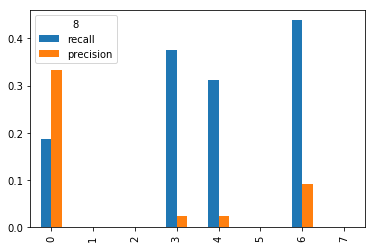

In [32]:
df.plot.bar(y=["recall","precision"])

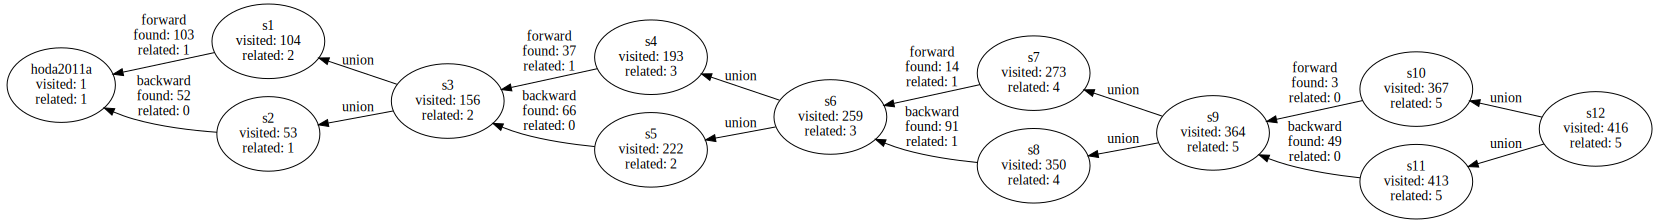

In [11]:
reload()
NAME = "hoda2011a"
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
seedset = {work_by_varname(NAME)}
strategy = Strategy(seedset, filter_function)
strategy.initial.name = NAME
state = strategy.sfbu()
state

## Strategy 2 - Database Search + Snowballing (Guideline Wohlin)

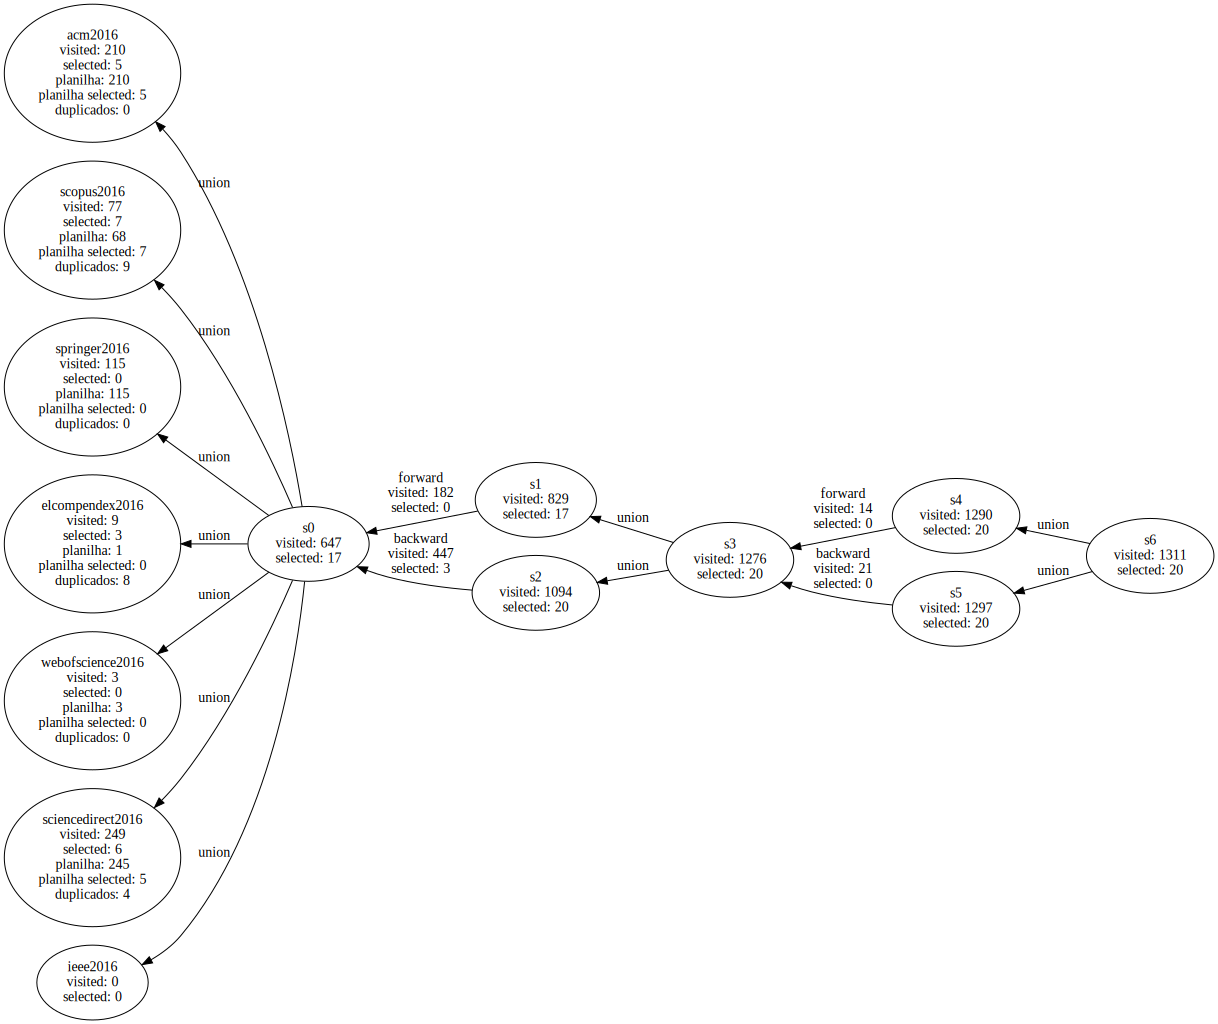

In [13]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2016", "scopus2016", "springer2016", "elcompendex2016", "webofscience2016", "sciencedirect2016", "ieee2016"], filter_function)
state = strategy.sfbu()

FinalSelection(state)

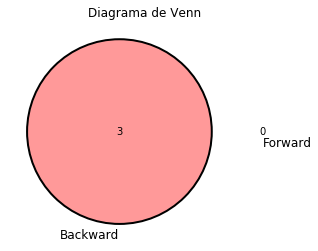

In [14]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [15]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['saddington2012a', 'eloranta2013a', 'barton2009a']
Forward []


In [16]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))
        
df

14,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,ieee2016,NaN,0.00,0.000,NaN,0.000,0.000,-,0,0,0,0,0,0,0.024,0.00,0.000,0.004,0.000,0.000
1,sciencedirect2016,0.024,0.30,0.045,0.000,0.000,0.000,-,6,249,0,6,249,1,0.024,0.30,0.045,0.004,0.143,0.008
2,webofscience2016,0.000,0.00,0.000,0.000,0.000,0.000,-,0,3,0,0,3,0,0.000,0.00,0.000,0.000,0.000,0.000
3,elcompendex2016,0.333,0.15,0.207,0.000,0.000,0.000,-,3,9,0,3,9,1,0.333,0.15,0.207,0.111,0.143,0.125
4,springer2016,0.000,0.00,0.000,0.000,0.000,0.000,-,0,115,0,0,115,0,0.000,0.00,0.000,0.000,0.000,0.000
5,scopus2016,0.091,0.35,0.144,0.000,0.000,0.000,-,7,77,0,7,77,2,0.091,0.35,0.144,0.026,0.286,0.048
6,acm2016,0.024,0.25,0.043,0.000,0.000,0.000,-,5,210,0,5,210,3,0.024,0.25,0.043,0.014,0.429,0.028
7,s0,NaN,0.00,0.000,NaN,0.000,0.000,union,0,0,0,17,647,6,0.026,0.85,0.051,0.009,0.857,0.018
8,s2,0.007,0.15,0.013,0.002,0.143,0.004,backward,3,447,1,20,1094,7,0.018,1.00,0.036,0.006,1.000,0.013
9,s1,0.000,0.00,0.000,0.000,0.000,0.000,forward,0,182,0,17,829,6,0.021,0.85,0.040,0.007,0.857,0.014


In [17]:
ndf

NameError: name 'ndf' is not defined

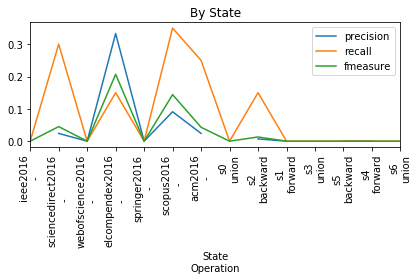

In [18]:
#ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

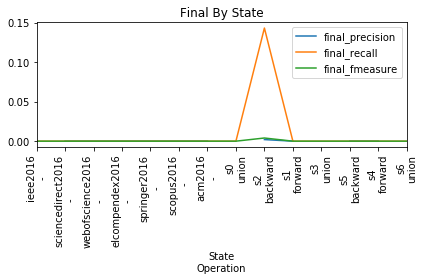

In [19]:
#ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

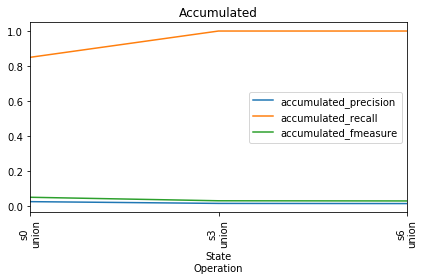

In [20]:
# ---- Grafico de linha para Somente Union 

ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
ndf['accumulated_precision'].plot(legend=True)
ndf['accumulated_recall'].plot(legend=True)
ndf['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()


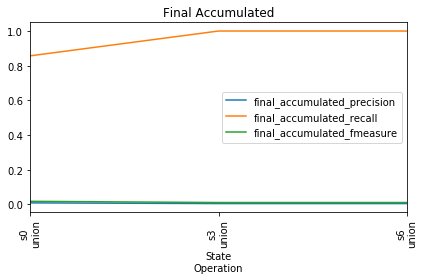

In [21]:
ndf = df.loc[df['operation'] == 'union'].reset_index(drop=True)
fig = plt.figure()
ndf['final_accumulated_precision'].plot(legend=True)
ndf['final_accumulated_recall'].plot(legend=True)
ndf['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(ndf["state"] + "\n" + ndf["operation"])
plt.xticks(np.arange(0, len(ndf), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Strategy 3 - Informal Search (Google Scholar) + Snowballing (Guideline Wohlin)

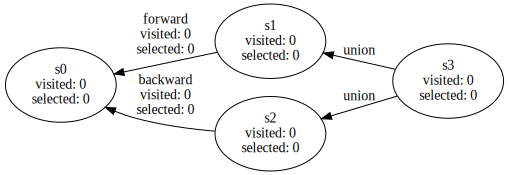

In [23]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs2016", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [24]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

UnboundLocalError: local variable 'accumulated_precision' referenced before assignment


## Strategy 4 - Scopus + Snowballing (Guideline Wohlin)

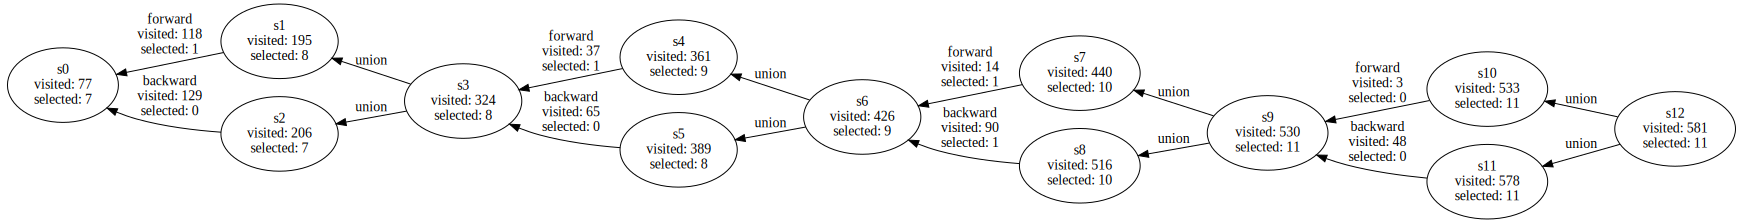

In [26]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))

state = strategy.sfbu()
FinalSelection(state)

In [27]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

13,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.091,0.35,0.144,0.000,0.000,0.000,-,7,77,0,7,77,2,0.091,0.35,0.144,0.026,0.286,0.048
1,s2,0.000,0.00,0.000,0.000,0.000,0.000,backward,0,129,0,7,206,2,0.034,0.35,0.062,0.010,0.286,0.019
2,s1,0.008,0.05,0.014,0.000,0.000,0.000,forward,1,118,0,8,195,2,0.041,0.40,0.074,0.010,0.286,0.020
3,s3,NaN,0.00,0.000,NaN,0.000,0.000,union,0,0,0,8,324,2,0.025,0.40,0.047,0.006,0.286,0.012
4,s5,0.000,0.00,0.000,0.000,0.000,0.000,backward,0,65,0,8,389,2,0.021,0.40,0.039,0.005,0.286,0.010
5,s4,0.027,0.05,0.035,0.000,0.000,0.000,forward,1,37,0,9,361,2,0.025,0.45,0.047,0.006,0.286,0.011
6,s6,NaN,0.00,0.000,NaN,0.000,0.000,union,0,0,0,9,426,2,0.021,0.45,0.040,0.005,0.286,0.009
7,s8,0.011,0.05,0.018,0.011,0.143,0.021,backward,1,90,1,10,516,3,0.019,0.50,0.037,0.006,0.429,0.011
8,s7,0.071,0.05,0.059,0.000,0.000,0.000,forward,1,14,0,10,440,2,0.023,0.50,0.043,0.005,0.286,0.009
9,s9,NaN,0.00,0.000,NaN,0.000,0.000,union,0,0,0,11,530,3,0.021,0.55,0.040,0.006,0.429,0.011


## Strategy 5 - Scopus + Snowballing (Short Paper)

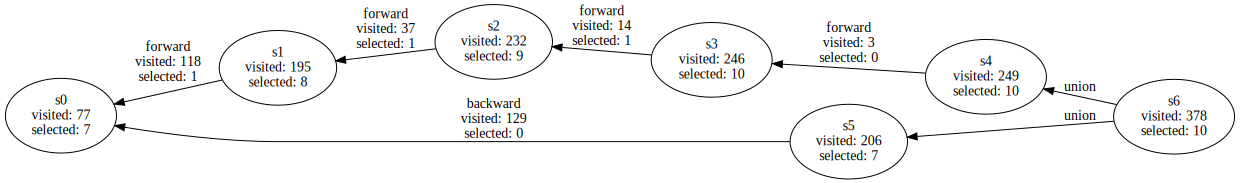

In [28]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [29]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s1,0.008,0.05,0.014,0.0,0.0,0,forward,1,118,0,8,195,2,0.041,0.40,0.074,0.010,0.286,0.020
1,s2,0.027,0.05,0.035,0.0,0.0,0,forward,1,37,0,9,232,2,0.039,0.45,0.071,0.009,0.286,0.017
2,s0,0.091,0.35,0.144,0.0,0.0,0,-,7,77,0,7,77,2,0.091,0.35,0.144,0.026,0.286,0.048
3,s3,0.071,0.05,0.059,0.0,0.0,0,forward,1,14,0,10,246,2,0.041,0.50,0.075,0.008,0.286,0.016
4,s5,0.000,0.00,0.000,0.0,0.0,0,backward,0,129,0,7,206,2,0.034,0.35,0.062,0.010,0.286,0.019
5,s4,0.000,0.00,0.000,0.0,0.0,0,forward,0,3,0,10,249,2,0.040,0.50,0.074,0.008,0.286,0.016
6,s6,NaN,0.00,0.000,NaN,0.0,0,union,0,0,0,10,378,2,0.026,0.50,0.050,0.005,0.286,0.010


## Strategy 6 - Scopus + Snowballing (JF BF)

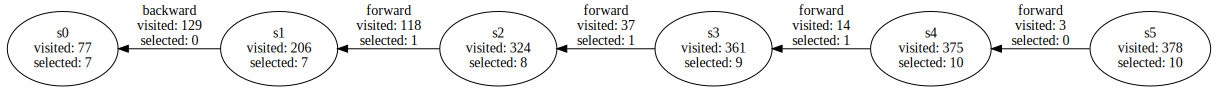

In [31]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [32]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

6,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.091,0.35,0.144,0.0,0.0,0,-,7,77,0,7,77,2,0.091,0.35,0.144,0.026,0.286,0.048
1,s1,0.000,0.00,0.000,0.0,0.0,0,backward,0,129,0,7,206,2,0.034,0.35,0.062,0.010,0.286,0.019
2,s2,0.008,0.05,0.014,0.0,0.0,0,forward,1,118,0,8,324,2,0.025,0.40,0.047,0.006,0.286,0.012
3,s3,0.027,0.05,0.035,0.0,0.0,0,forward,1,37,0,9,361,2,0.025,0.45,0.047,0.006,0.286,0.011
4,s4,0.071,0.05,0.059,0.0,0.0,0,forward,1,14,0,10,375,2,0.027,0.50,0.051,0.005,0.286,0.010
5,s5,0.000,0.00,0.000,0.0,0.0,0,forward,0,3,0,10,378,2,0.026,0.50,0.050,0.005,0.286,0.010


## Strategy 7 - Scopus + Snowballing (JF FB)

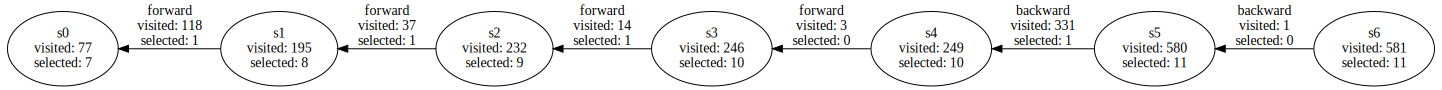

In [34]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2016", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [35]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

d_decimals = 3    
for coluna in ['precision', 'recall', 'fmeasure', 'final_precision', 'final_recall', 'final_fmeasure','delta_related', 'delta_visited', 'delta_selected','related', 'visited', 'final_selected','accumulated_precision', 'accumulated_recall', 'accumulated_fmeasure','final_accumulated_precision', 'final_accumulated_recall', 'final_accumulated_fmeasure']:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.091,0.35,0.144,0.000,0.000,0.000,-,7,77,0,7,77,2,0.091,0.35,0.144,0.026,0.286,0.048
1,s1,0.008,0.05,0.014,0.000,0.000,0.000,forward,1,118,0,8,195,2,0.041,0.40,0.074,0.010,0.286,0.020
2,s2,0.027,0.05,0.035,0.000,0.000,0.000,forward,1,37,0,9,232,2,0.039,0.45,0.071,0.009,0.286,0.017
3,s3,0.071,0.05,0.059,0.000,0.000,0.000,forward,1,14,0,10,246,2,0.041,0.50,0.075,0.008,0.286,0.016
4,s4,0.000,0.00,0.000,0.000,0.000,0.000,forward,0,3,0,10,249,2,0.040,0.50,0.074,0.008,0.286,0.016
5,s5,0.003,0.05,0.006,0.003,0.143,0.006,backward,1,331,1,11,580,3,0.019,0.55,0.037,0.005,0.429,0.010
6,s6,0.000,0.00,0.000,0.000,0.000,0.000,backward,0,1,0,11,581,3,0.019,0.55,0.037,0.005,0.429,0.010


# Analyses

In [36]:
%matplotlib inline
import pandas as pd

In [37]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df
print (array)

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

[['E1', 17, 935, 6, 0.01818181818181818, 1.0625, 0.035751840168243953, 0.006417112299465241, 0.8571428571428571, 0.012738853503184712], ['E2', 20, 1311, 7, 0.015255530129672006, 1.0, 0.03005259203606311, 0.005339435545385202, 1.0, 0.010622154779969651], ['E4', 11, 581, 3, 0.0189328743545611, 0.55, 0.036605657237936774, 0.0051635111876075735, 0.42857142857142855, 0.010204081632653062], ['E5', 10, 378, 2, 0.026455026455026454, 0.5, 0.05025125628140703, 0.005291005291005291, 0.2857142857142857, 0.01038961038961039], ['E6', 10, 378, 2, 0.026455026455026454, 0.5, 0.05025125628140703, 0.005291005291005291, 0.2857142857142857, 0.01038961038961039], ['E7', 11, 581, 3, 0.0189328743545611, 0.55, 0.036605657237936774, 0.0051635111876075735, 0.42857142857142855, 0.010204081632653062]]


,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,17,935,6,0.02,1.06,0.04,0.01,0.86,0.01
E2,E2,20,1311,7,0.02,1.00,0.03,0.01,1.00,0.01
E4,E4,11,581,3,0.02,0.55,0.04,0.01,0.43,0.01
E5,E5,10,378,2,0.03,0.50,0.05,0.01,0.29,0.01
E6,E6,10,378,2,0.03,0.50,0.05,0.01,0.29,0.01
E7,E7,11,581,3,0.02,0.55,0.04,0.01,0.43,0.01


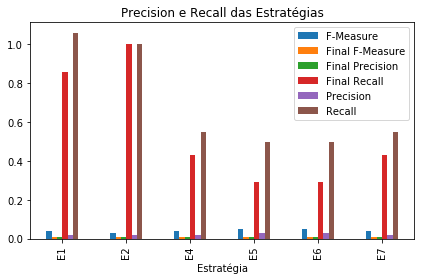

In [38]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [39]:
df

d_decimals = 2    
for coluna in ['Precision', 'Recall', 'F-Measure', 'Final Precision', 'Final Recall', 'Final F-Measure',]:
      df[coluna] = df[coluna].apply(lambda x: round(x,d_decimals))

df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,17,935,6,0.02,1.06,0.04,0.01,0.86,0.01
E2,E2,20,1311,7,0.02,1.00,0.03,0.01,1.00,0.01
E4,E4,11,581,3,0.02,0.55,0.04,0.01,0.43,0.01
E5,E5,10,378,2,0.03,0.50,0.05,0.01,0.29,0.01
E6,E6,10,378,2,0.03,0.50,0.05,0.01,0.29,0.01
E7,E7,11,581,3,0.02,0.55,0.04,0.01,0.43,0.01


In [40]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")

In [ ]:
#len ({x for _, x in load_work_map_all_years() if x.category == "snowball"})

In [ ]:
#{x for _, x in load_work_map_all_years() if x.category == "snowball"} @ metakey_title